# Dependencies

In [ ]:
# Paths and directories
import os
import shutil


# Data Science basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand
import numpy as np

# Modelling
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn.metrics import classification_report

# Image processing
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Useful Code

In [3]:
# def recolor(img):
#     return cv2.applyColorMap(img.astype('float'), cv2.COLORMAP_JET)

# Define an image generator for train, validation and test data
# This will help in saving RAM, as there are no heavy arrays to be stored implicitly
def image_generator(train_parent_directory, test_parent_directory):
    
    """
    Build train, test and evaluation image generators to feed models during training and testing, 
    given training and testing image directories. 
    
    Training data is split with 20% going to an evaluation dataset. Image augmentation is performed randomly by
    horizontally flipping images. All image arrays are rescaled to values between 0 and 1. The final arrays will be 356x356
    and will be generated in batches of 5 for training and evaluation data, whereas batches of 1 for testing.
    """
    
    # Instanciate generators and image pre-processing steps
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.2, horizontal_flip = True) #, preprocessing_function = recolor)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Specify parameters of data input to a model for train, validaiton and test
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                        target_size = (356, 356),
                                                        seed = 42,
                                                        batch_size = 5, 
                                                        class_mode = 'sparse', 
                                                        subset='training')
    
    val_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                      target_size = (356, 356),
                                                      seed = 42,
                                                      batch_size = 5, 
                                                      class_mode = 'sparse', 
                                                      subset='validation')
 
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                                      target_size = (356, 356),
                                                      batch_size = 1,
                                                      class_mode = None,
                                                      shuffle = False)    
    
    return train_generator, val_generator, test_generator

In [4]:
def plot_learning_curves(model_history, validation = False):
    
    """
    Plot accuracy and loss through training epochs, with or without a validation set
    """
    
    df = pd.DataFrame(model_history.history)
    df['epoch'] = range(len(df))

    fig, ax = plt.subplots(1, 2, figsize = (10,4))
    plt.suptitle('Learning curves')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')

    if validation == False:
        sns.lineplot(data = df['accuracy'], ax = ax[0])
        sns.lineplot(data = df['loss'], ax = ax[1])
    else:
        sns.lineplot(data = df[['accuracy', 'val_accuracy']], ax = ax[0])
        ax[0].legend(['training', 'validation'])
        
        sns.lineplot(data = df[['loss', 'val_loss']], ax = ax[1])
        ax[1].legend(['training', 'validation'])
        
        return

In [5]:
def find_max(pred):
    
    """
    Find max probability from preditions
    """
    
    int_pred = []
    for row in pred:
        int_pred.append(list(row).index(row.max()))
    
    return int_pred

def full_classification_report(test_gen, model):
    
    """
    Produce classification report of a test dataset for a model
    """
    
    y_pred = model.predict(test_gen)
    print('############ TEST SET CLASSIFICATION REPORT ############\n\n', 
          classification_report(test_gen.classes, find_max(y_pred)))
    
    return

def model_evaluate(model, history, test_gen, val = False):
    
    """
    Plot learning curves and the full classification report of a model given training, test and optionally validation data
    """
    
    plot_learning_curves(history, validation = val)
    full_classification_report(test_gen, model)
    
    return

## Convolutional Neural Networks

In [6]:
# Define train and test dirs
train_dir = os.path.join('../input/happywhale-sample-resized/train_set')
test_dir = os.path.join('../input/happywhale-sample-resized/test_set')

In [7]:
# Get train, validation and test data generators
train_generator, val_generator, test_generator = image_generator(train_dir, test_dir)

Found 3173 images belonging to 5 classes.
Found 792 images belonging to 5 classes.
Found 992 images belonging to 5 classes.


In [8]:
# Define and describe model
cnn = models.Sequential([

    # Convolution an pooling layers
    Conv2D(input_shape=(356, 356, 3), filters = 10, kernel_size = (3, 3), activation = 'relu'),
    MaxPooling2D(),

    Conv2D(filters = 10, kernel_size = (3, 3), activation = 'relu'),
    MaxPooling2D(),
    
    Conv2D(filters = 10, kernel_size = (3, 3), activation = 'relu'),
    MaxPooling2D(),

    # Flatten layer
    Flatten(),

    # Dense layers
    Dense(units = 100, activation = 'relu'),

    # Dropout layer
    Dropout(0.2),

    # Final softmax layer
    Dense(units = 5, activation = 'softmax')

])

cnn.compile(optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy'])

2022-03-30 19:10:07.876669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 19:10:07.959067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 19:10:07.959753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 19:10:07.960919: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

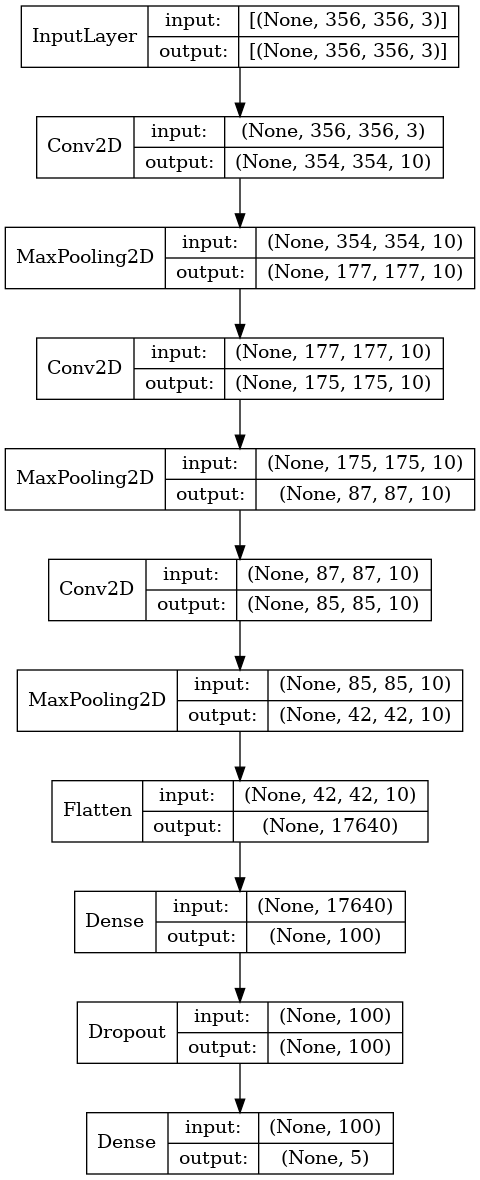

In [9]:
plot_model(cnn, show_layer_names = False, show_shapes = True, expand_nested = True)

In [10]:
# Model training
cnn_hist = cnn.fit(train_generator, validation_data = val_generator, epochs = 5)

2022-03-30 19:10:11.056614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-03-30 19:10:12.367421: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


635/635 [==============================] - 37s 48ms/step - loss: 1.0869 - accuracy: 0.5676 - val_loss: 0.8393 - val_accuracy: 0.6629
Epoch 2/5
635/635 [==============================] - 18s 29ms/step - loss: 0.8525 - accuracy: 0.6760 - val_loss: 0.7537 - val_accuracy: 0.7096
Epoch 3/5
635/635 [==============================] - 19s 30ms/step - loss: 0.7172 - accuracy: 0.7343 - val_loss: 0.7037 - val_accuracy: 0.7222
Epoch 4/5
635/635 [==============================] - 18s 29ms/step - loss: 0.6594 - accuracy: 0.7564 - val_loss: 0.7064 - val_accuracy: 0.7247
Epoch 5/5
635/635 [==============================] - 19s 31ms/step - loss: 0.5788 - accuracy: 0.7898 - val_loss: 0.6681 - val_accuracy: 0.7412


############ TEST SET CLASSIFICATION REPORT ############

               precision    recall  f1-score   support

           0       0.77      0.83      0.80       174
           1       0.52      0.67      0.58       250
           2       0.82      0.60      0.69       250
           3       0.92      0.84      0.87       250
           4       0.36      0.37      0.36        68

    accuracy                           0.70       992
   macro avg       0.67      0.66      0.66       992
weighted avg       0.73      0.70      0.71       992



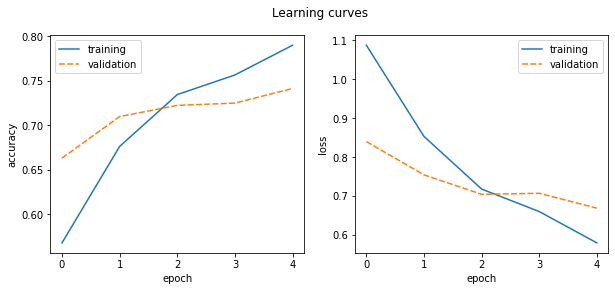

In [11]:
# Model evaluation
model_evaluate(cnn, cnn_hist, test_generator, val = True)

May be slightly overfit, L1 and L2 regularisation dont seem to help.

In [13]:
def plot_random_prediction(model, ind = None, y_pred = None):
    
    """Plot the image classification prediction for a model, optionally, specify the observation"""
    
    # If observation is not specified pick a random one
    if (ind == None) and (y_pred == None):
        ind = rand.sample(range(len(test_generator)-1), 1)[0]
        y_pred = model.predict(test_generator[ind])
    
    labs = test_generator.classes
    lab_dic = {v: k for k, v in test_generator.class_indices.items()}

    plt.title('Actual: '+lab_dic[labs[ind]]+'\nPredicted: '+lab_dic[np.argmax(y_pred)])
    plt.imshow(test_generator[ind][0])
    plt.axis('off')
    
    return
    
def plot_sample_predictions(model, n = 9):
    
    """Plot 'n' random sample image classification predictions of a model"""
    
    plt.figure(figsize = (10, 11))
    for each in range(n):
        plt.subplot(int(n/3), 3, each+1)
        plot_random_prediction(model)
    plt.show()
    
    return

In [106]:
def plot_rd_pred_probs(model):
    
    """
    Plot softmax probabilities next to an image and its actual plus predicted classifications
    """
    
    # Specify random observation
    ind = rand.sample(range(len(test_generator)-1), 1)[0]
    y_pred = list(model.predict(test_generator[ind])[0])
    
    plot_data = pd.DataFrame(list(zip(y_pred, test_generator.class_indices.keys())))
    plot_data.columns = ['Softmax Probabilities', 'Families']

    # Plot
    plt.figure(figsize = (10, 5))
    
    # Softmax plot
    plt.subplot(1,2,2)
    plot_random_prediction(cnn, ind = ind, y_pred = y_pred)
    
    # Classification plot
    plt.subplot(1,2,1)
    plt.bar(plot_data['Families'], plot_data['Softmax Probabilities'], 1, color = ['blue', 'orange', 'green', 'red', 'purple']) #, color = ['blue', 'green', 'red', 'yellow', 'purple'])
    plt.ylabel('Softmax probability')
    plt.xlabel('Cetacean Families')
    plt.xticks(rotation = 45 ,ha = 'right')
    plt.ylim([0,1])

    plt.show()
    
    return

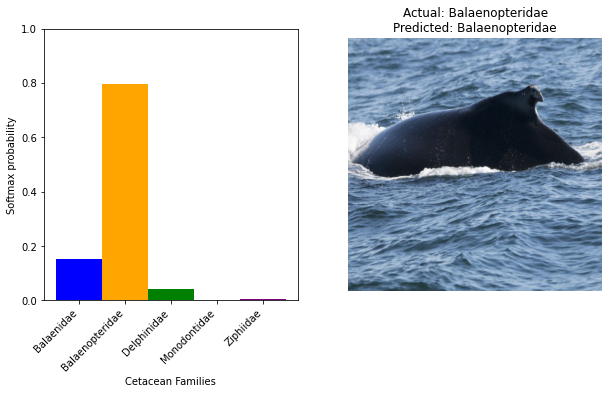

In [109]:
plot_rd_pred_probs(cnn)

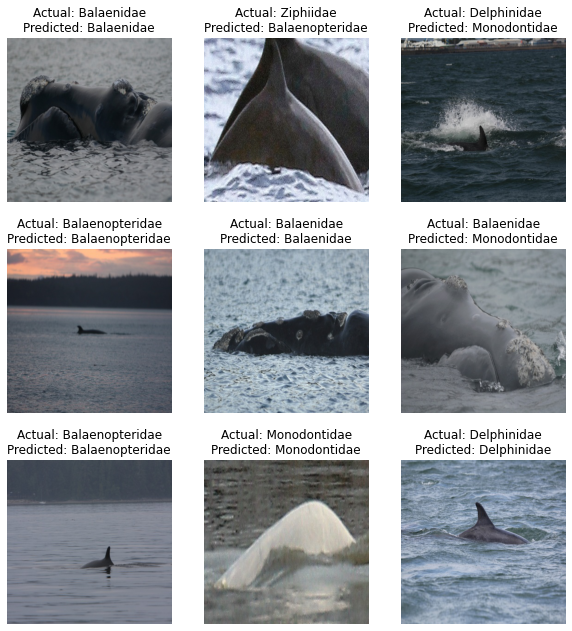

In [88]:
plot_sample_predictions(cnn)

## Bayesian perspective on CNN

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam

In [ ]:
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
gauss_prior = tfpl.default_multivariate_normal_fn
gauss_bias_prior = tfpl.default_multivariate_normal_fn

In [ ]:
gauss_post = tfpl.default_mean_field_normal_fn(is_singular=False)
gauss_bias_post = tfpl.default_mean_field_normal_fn(is_singular=False)

In [ ]:
KL_div = lambda q,p,_: tfd.kl_divergence(q,p)/train_generator.samples

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Define and describe model
cnn_bayes = models.Sequential([

    # Bayesian convolution and pooling layers
    tfpl.Convolution2DReparameterization(
        input_shape=(356,356,3),
        filters=10,
        kernel_size=(4,4),
        activation='relu',
        kernel_prior_fn = gauss_prior,
        kernel_posterior_fn = gauss_post,
        kernel_divergence_fn = KL_div,
        bias_prior_fn = gauss_bias_prior,
        bias_posterior_fn = gauss_bias_post,
        bias_divergence_fn = KL_div),
    MaxPooling2D(2,2),
    
    # Convolution and pooling layers
    Conv2D(filters = 10, kernel_size = (3, 3), activation = 'relu'),
    MaxPooling2D(2,2),
    
    Conv2D(filters = 10, kernel_size = (3, 3), activation = 'relu'),
    MaxPooling2D(2,2),

    # Flatten layer
    Flatten(),

    # Dense layers
    Dense(units = 100, activation = 'relu'),

    # Dropout layer
    Dropout(0.2),

    # Final softmax layer
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(5), 
                                 activation='softmax',
                                 kernel_prior_fn = gauss_prior,
                                 kernel_posterior_fn=gauss_post,
                                 kernel_divergence_fn = KL_div,
                                 bias_prior_fn = gauss_bias_prior,
                                 bias_posterior_fn=gauss_bias_post,
                                 bias_divergence_fn = KL_div),
    tfpl.OneHotCategorical(5)

])

def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

cnn_bayes.compile(optimizer=Adam(learning_rate=0.005), 
                  loss='mse', 
                  metrics=['accuracy'],
                  experimental_run_tf_function = False)

In [ ]:
cnn_bayes_hist = cnn_bayes.fit(train_generator, validation_data = val_generator, epochs = 10)

In [ ]:
model_evaluate(cnn_bayes, cnn_bayes_hist, test_generator, val = True)

This model did not yield good results. More Bayesian methods can be investigated.